In [29]:
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [30]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [31]:
load_dotenv()

fred_api_key = os.getenv("fred_api_key")
fred = Fred(api_key=fred_api_key)

In [32]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [33]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [34]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, model_stats_df)
                              
model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, model_stats_df )                         

model_stats_df

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,25.4002,5.0399,2.1100,4.4310,0
1,ffef_tr_test,57.2779,7.5682,41.6492,6.8936,0
2,ffef_tr2_train,1.1202,1.0584,0.2525,0.6816,0
3,ffef_tr2_test,0.3307,0.5750,3.4681,0.4071,0


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

# Load Data

In [35]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE < "2007-09-30"')
train_df, test_df = time_split(taylor_df)

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


In [36]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

In [37]:
#case = 1  # Taylor Rule
#scase = 2  # Modified Taylor Rule drop AR term
#case = 3  # Modified Taylor Rule
#case = 4  # FUll Model
#case = 5  # Modified Taylor Rule drop inflation
#case = 6  # Modified Taylor Rule drop inflation
case = 7  # Modified Taylor Rule drop inflation
#case = 8  # Modified Taylor Rule drop inflation
#case = None  # Extened Taylor Rule

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    print('-- Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_gdp']]
    y_train = train_df['FEDFUNDS']

    X_test = test_df[['gap_inf', 'gap_gdp',]]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_gdp']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 2:
    print('-- Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue',]]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 3:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 4:
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    rscaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #norm_num = Normalizer()
    #pt_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','gap_ue']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('rscaler_num',rscaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
                       
                       
elif case == 5:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 6:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 7:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 8:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
else:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

-- Taylor Rule Extened


In [38]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (197, 4)


# Lasso

In [39]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.01118420293975338


In [40]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: 0.8638685282832469 Parameters: {} {'model__verbose': 0}


In [41]:
lasso_best = linear_model.Lasso(alpha=cv.best_estimator_.named_steps.model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [42]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__FEDFUNDS-1,0.920117
cat__onehotencoder__recession_flag_True,-0.839546
num__gap_inf,0.131263
num__gap_ue,-0.124278


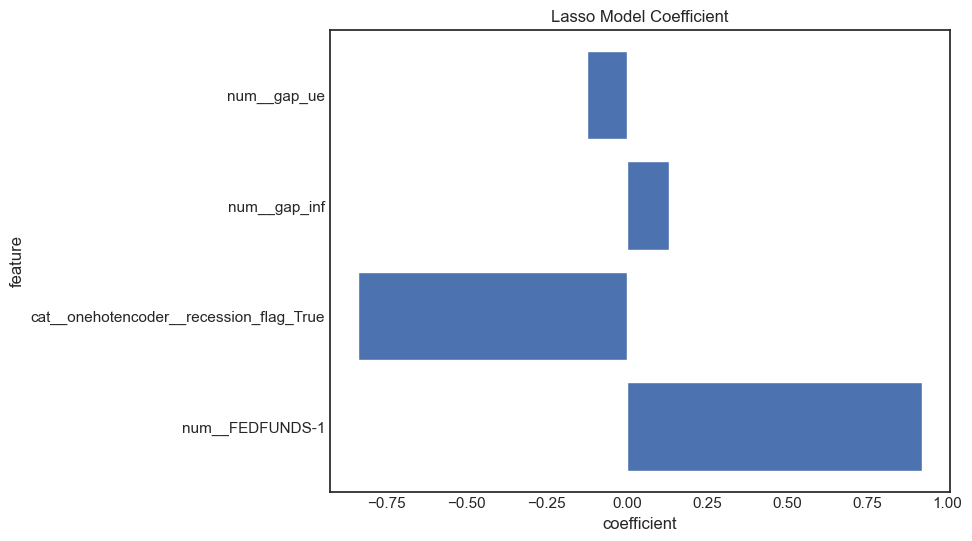

In [43]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

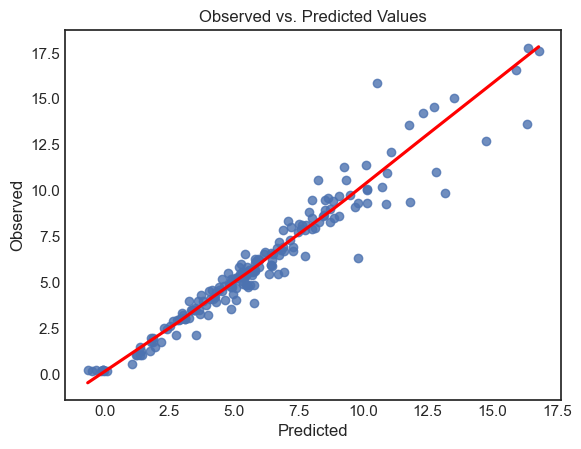

In [44]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

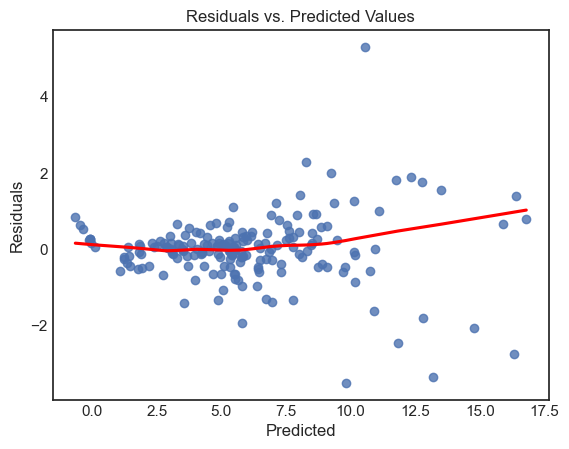

In [45]:
# independence of residuals

residuals = y_train - train_pred_lasso

fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

In [46]:
# values for durbin watson test is between 0 and 4 the value close to 2 is accurate
# Durbin-Watson Test: Provides a measure (statistic) that ranges from 0 to 4. A value around 2 
# suggests no autocorrelation. Values closer to 0 indicate positive autocorrelation, 
# while values near 4 suggest negative autocorrelation.

durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.7188008740474983


In [47]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# p-value < 0.05 - reject the null hypothesis residuals are not normally distrivuted
# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))


# Check for normality based on the p-value
alpha = 0.05  # Set a significance level
if shapiro_test.pvalue > alpha:
    print("Sample looks Gaussian (fail to reject H0 - data is normally distributed)")
else:
    print("Sample does not look Gaussian (reject H0 - data is not normally distributed)")

Shapiro-Wilk Test Statistic: 0.8539187908172607
Shapiro-Wilk p-value: 0.0
Sample does not look Gaussian (reject H0 - data is not normally distributed)


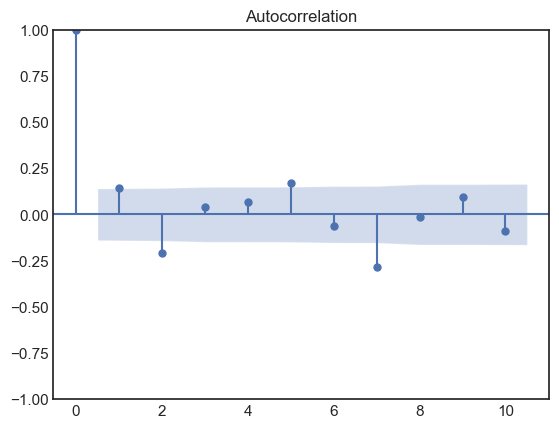

In [48]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [49]:
#model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

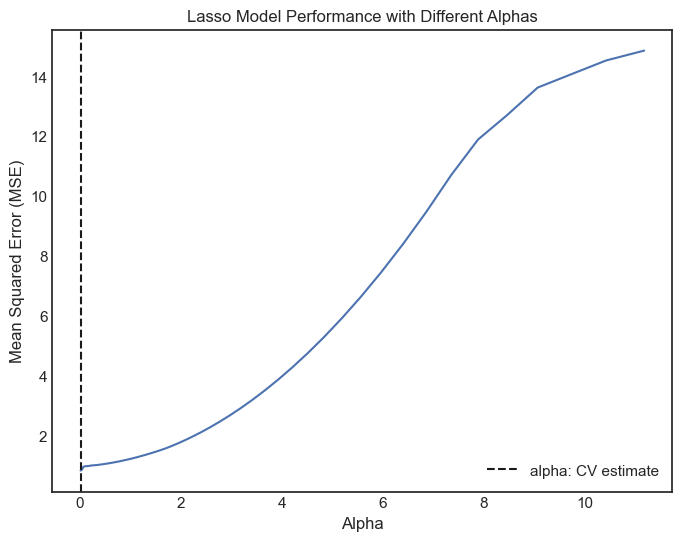

In [50]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

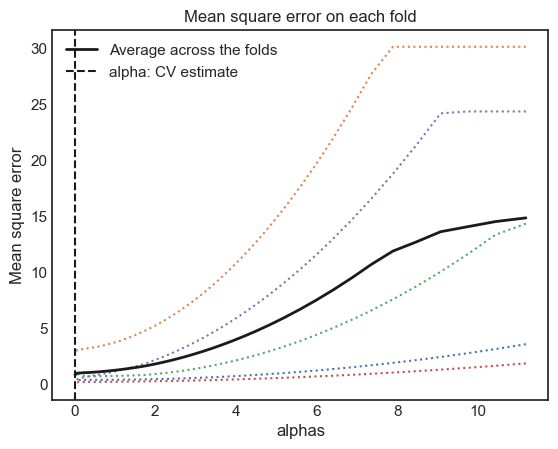

In [51]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
plt.show()
#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

## Test

In [52]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_const: ', X_test_trf.shape)

X_test_const:  (49, 4)


In [53]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


In [54]:
residuals = y_test - test_pred_lasso

In [55]:
#model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

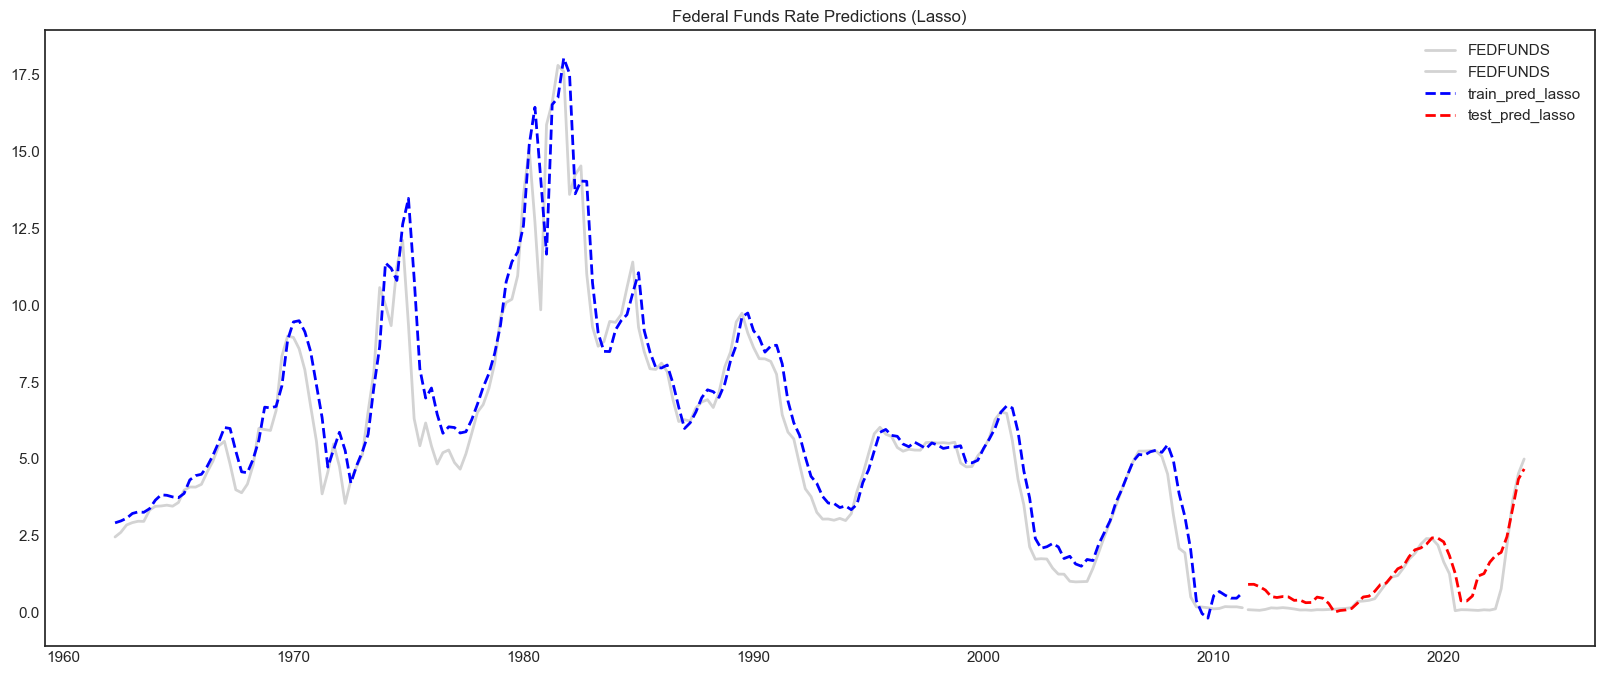

In [56]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_df['ffef_tr2'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_df.index, test_df['ffef_tr2'], color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

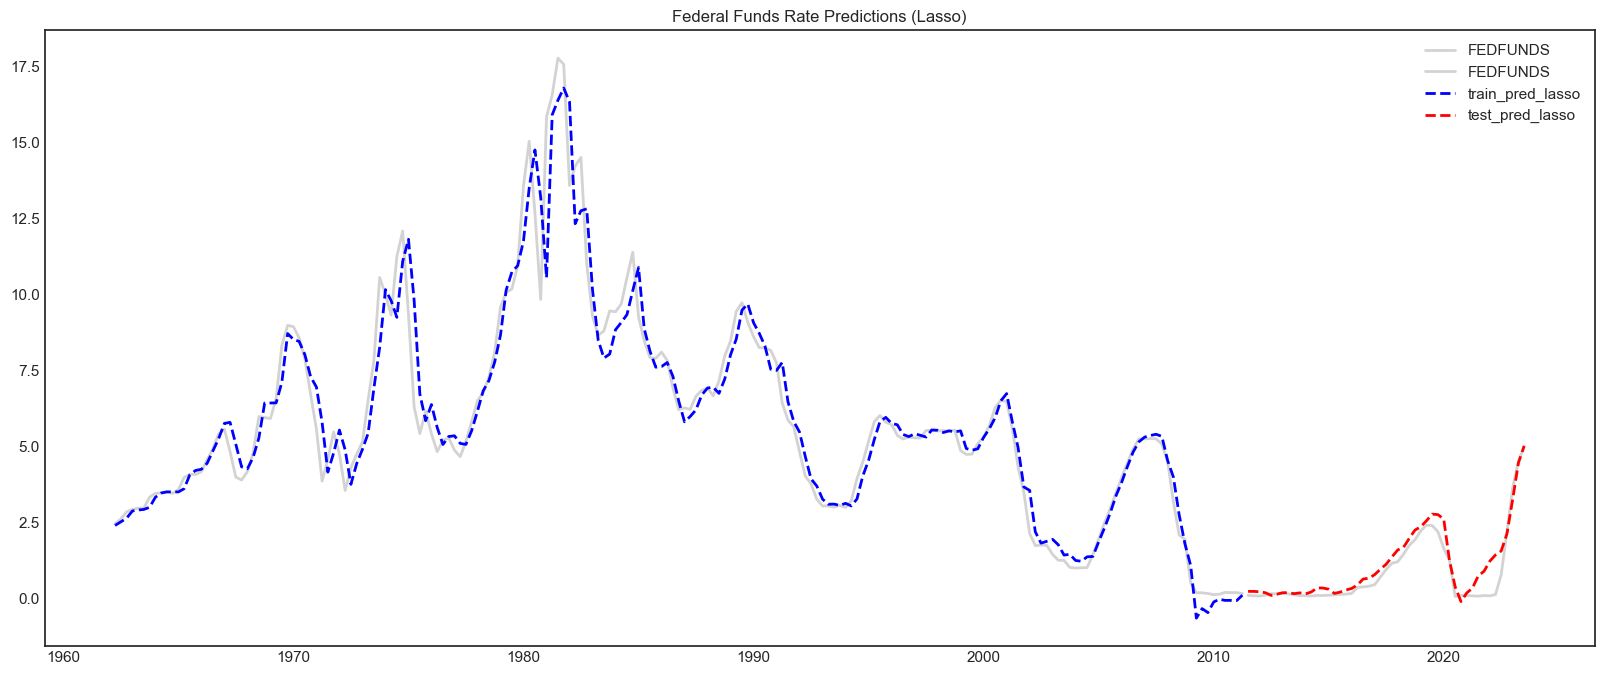

In [57]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_df.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# Sharpe

In [58]:
model = cv.best_estimator_.named_steps.model
model

LassoCV(cv=5, max_iter=10000, random_state=12, verbose=0)

In [59]:
explainer = None
shap_values = None

In [60]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

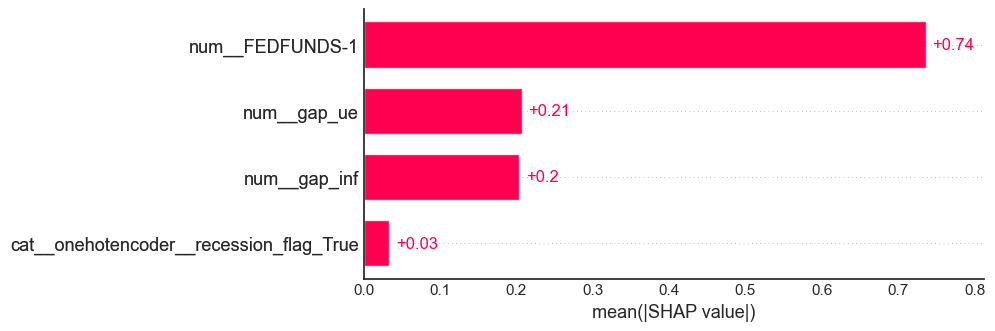

In [61]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

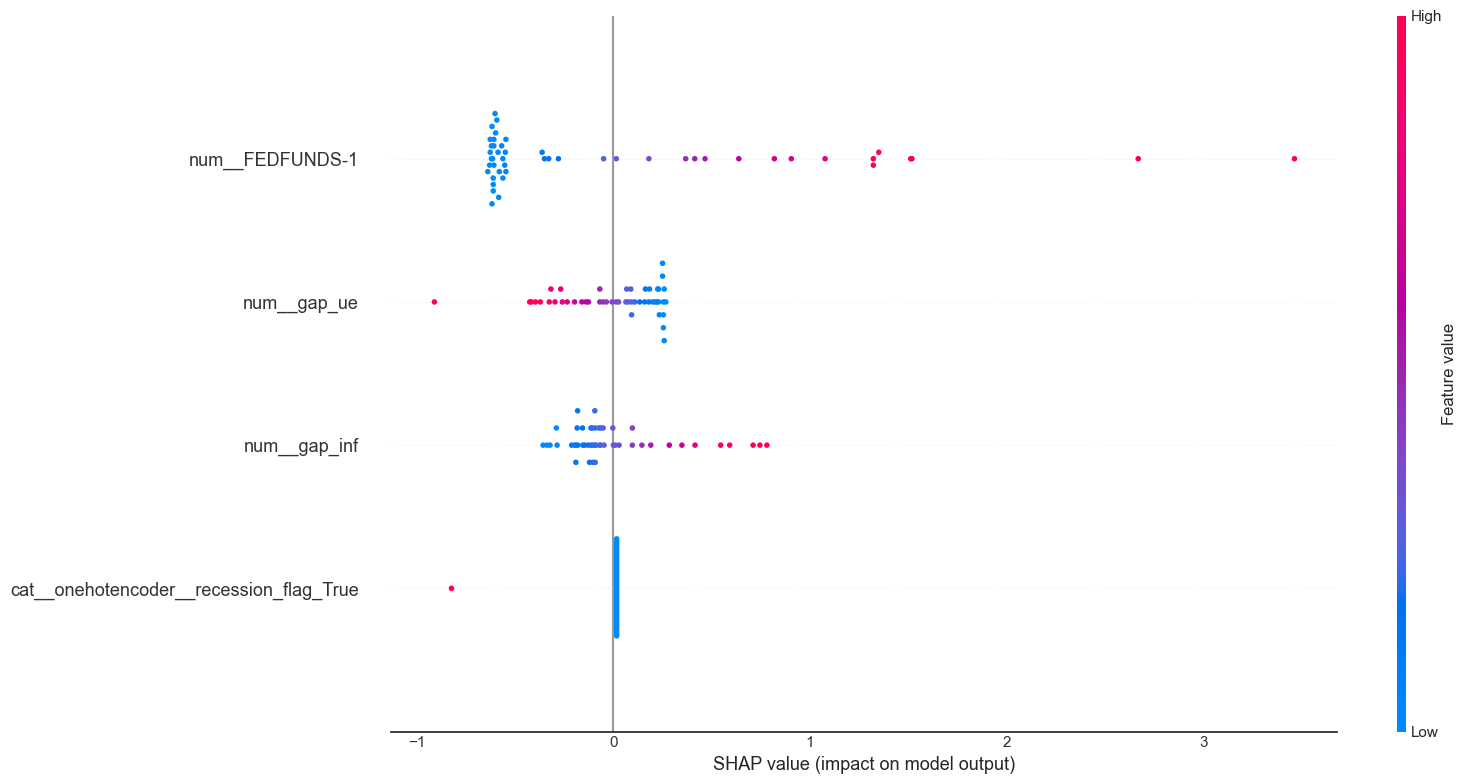

In [62]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(16,8))

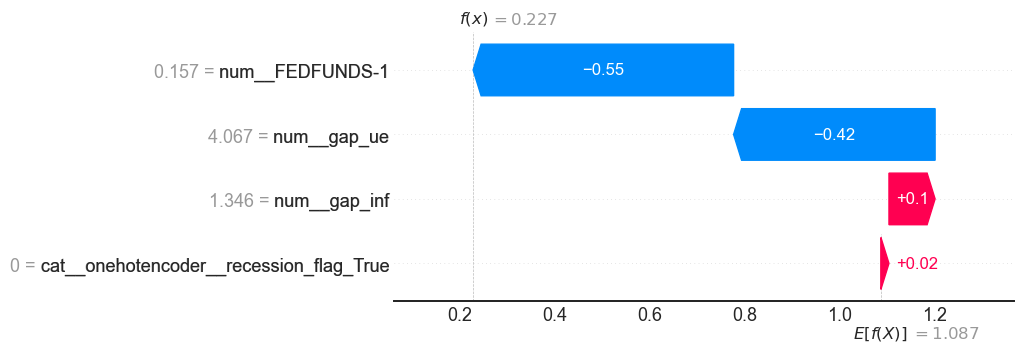

In [63]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


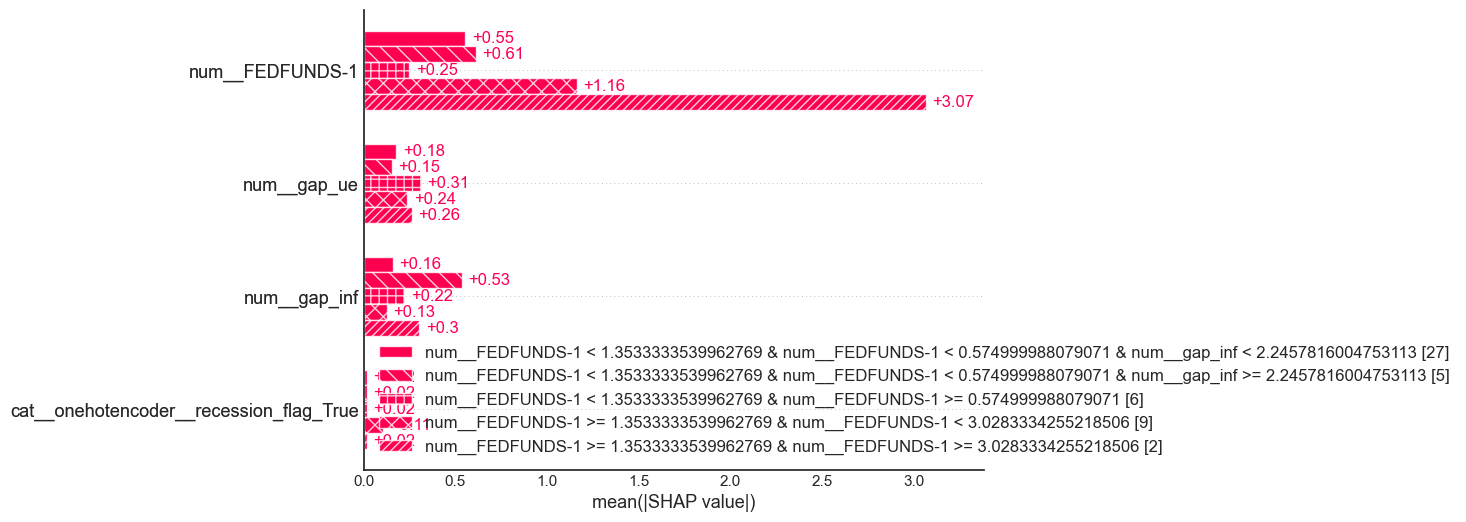

In [64]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [65]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

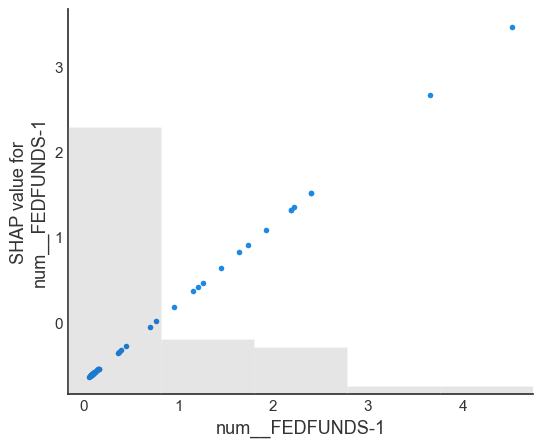

In [66]:
if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__FEDFUNDS-1"])

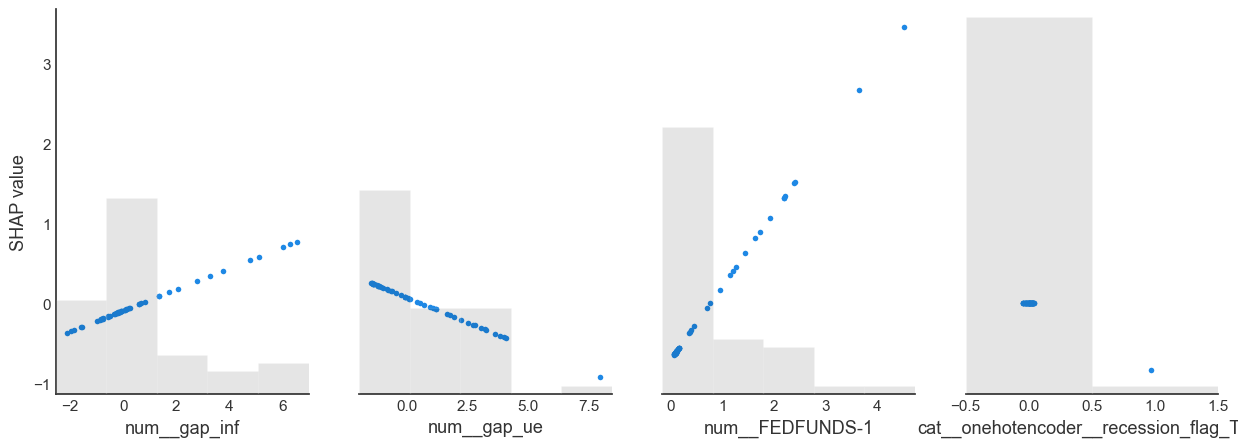

In [67]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

In [68]:
model_stats_df

,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,25.4002,5.0399,2.1100,4.4310,0
1,ffef_tr_test,57.2779,7.5682,41.6492,6.8936,0
2,ffef_tr2_train,1.1202,1.0584,0.2525,0.6816,0
3,ffef_tr2_test,0.3307,0.5750,3.4681,0.4071,0
